In [49]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import pandas as pd
from src.rename import abbreviate_feature_sets
from src.preprocess import stratify4
import os

In [50]:
#baseline features
features_tanya = ['gag_lrtt', 'gp120_lrtt', 'pol_lrtt',
                  'gp41_tips', 'gag_tips', 'gp120_tips',
                  'gp41_maf12c',
                  'gag_maf3c', 'gp41_maf3c']
#additional features to add
additional_features = ['genome_ambig', 'pol_ambig', 'gp120_ambig', 
                       'lrtt_coeff_1', 'lrtt_coeff_11']

feature_sets = {}
feature_sets['base'] = features_tanya
for feature in additional_features:
    feature_sets[f'base_plus_{feature}'] = features_tanya + [feature]

for i in range(1, len(additional_features) + 1):
    for combo in combinations(additional_features, i):
        combo_name = "_".join(combo)
        feature_sets[f'base_plus_{combo_name}'] = features_tanya + list(combo)

#data directory to pspline train-test sets
data_dir = './data/derived/smoothed/pspline_10folds/'

In [51]:
#Strata of TSI
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])

In [52]:
all_results = pd.DataFrame()
all_class_wise_accuracies_list = []

for feature_set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {feature_set_name}")
    
    accuracy_scores = []
    f1_scores = []
    
    #Iterate through 10 folds
    for fold in range(1, 11):
        # Load the pre-split training and test data for current fold
        train_file = os.path.join(data_dir, f'training_data_fold{fold}.csv')
        test_file = os.path.join(data_dir, f'test_data_fold{fold}.csv')
        
        train_data = pd.read_csv(train_file)
        test_data = pd.read_csv(test_file)

        # Encode TSI categories as ordinal
        train_data['TSI_encoded'] = ordinal_encoder.fit_transform(train_data[['TSI_category']])
        test_data['TSI_encoded'] = ordinal_encoder.transform(test_data[['TSI_category']])

        # define x and y for train-test
        X_train = train_data[features]
        y_train = train_data['TSI_encoded']
        X_test = test_data[features]
        y_test = test_data['TSI_encoded']  
        
        # Train default model
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train) #fit model
        y_pred = model.predict(X_test) #generate predictions
        
        # Compute and store metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}, F1-score = {f1:.4f}")
        
        # Calculate class-wise accuracies
        classes = np.unique(y_train)
        for cls in classes:
            mask = y_test == cls
            if np.sum(mask) > 0:
                class_accuracy = accuracy_score(y_test[mask], y_pred[mask])
            else:
                class_accuracy = np.nan  # Handle case where no samples are present for the class in this fold
            
            all_class_wise_accuracies_list.append({
                'Feature_Set': feature_set_name,
                'Fold': fold,
                'Class': cls,
                'Accuracy': class_accuracy
            })

    # Append fold-wise metrics to the results DataFrame
    results_df = pd.DataFrame({
        'Feature_Set': feature_set_name,
        'Fold': range(1, 11),
        'Accuracy': accuracy_scores,
        'F1_Score': f1_scores
    })
    
    all_results = pd.concat([all_results, results_df], ignore_index=True)
all_class_wise_accuracies = pd.DataFrame(all_class_wise_accuracies_list)

Evaluating feature set: base
Fold 1: Accuracy = 0.4394, F1-score = 0.4579
Fold 2: Accuracy = 0.6167, F1-score = 0.5529
Fold 3: Accuracy = 0.5238, F1-score = 0.4876
Fold 4: Accuracy = 0.5312, F1-score = 0.4712
Fold 5: Accuracy = 0.5758, F1-score = 0.5480
Fold 6: Accuracy = 0.6032, F1-score = 0.5691
Fold 7: Accuracy = 0.6418, F1-score = 0.6190
Fold 8: Accuracy = 0.6129, F1-score = 0.5849
Fold 9: Accuracy = 0.5312, F1-score = 0.4815
Fold 10: Accuracy = 0.5625, F1-score = 0.5332
Evaluating feature set: base_plus_genome_ambig
Fold 1: Accuracy = 0.5303, F1-score = 0.5414
Fold 2: Accuracy = 0.6167, F1-score = 0.5446
Fold 3: Accuracy = 0.5079, F1-score = 0.4647
Fold 4: Accuracy = 0.5469, F1-score = 0.4964
Fold 5: Accuracy = 0.5758, F1-score = 0.5476
Fold 6: Accuracy = 0.6190, F1-score = 0.5906
Fold 7: Accuracy = 0.5821, F1-score = 0.5639
Fold 8: Accuracy = 0.6129, F1-score = 0.5845
Fold 9: Accuracy = 0.5781, F1-score = 0.5242
Fold 10: Accuracy = 0.5625, F1-score = 0.5371
Evaluating feature set

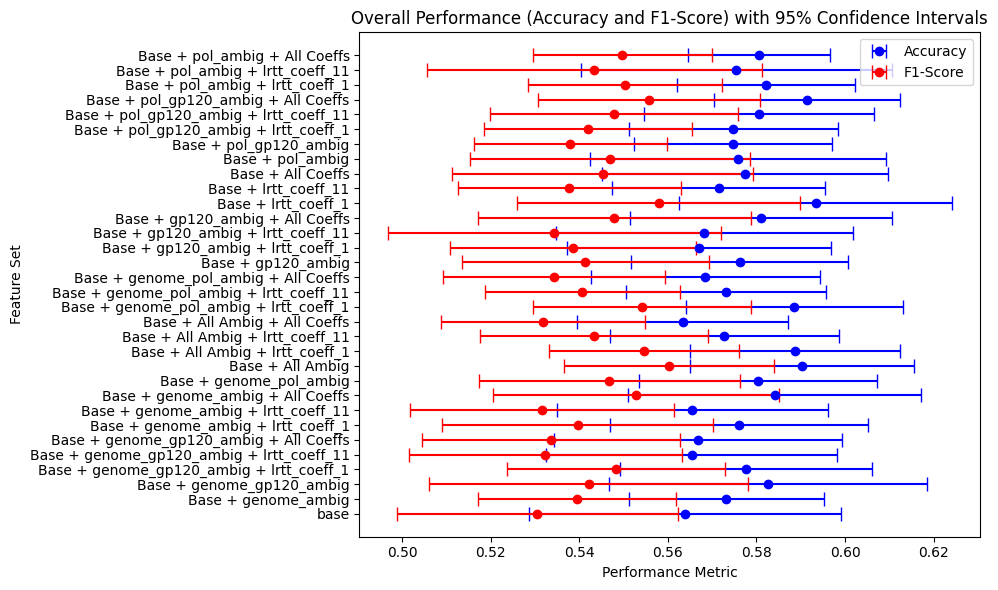

In [53]:
#aggregate byt feature sets
summary_results = all_results.groupby('Feature_Set').agg(
    mean_accuracy=('Accuracy', 'mean'),
    mean_f1_score=('F1_Score', 'mean'),
    ci_accuracy=('Accuracy', lambda x: 1.96 * np.std(x) / np.sqrt(len(x))),
    ci_f1_score=('F1_Score', lambda x: 1.96 * np.std(x) / np.sqrt(len(x)))
).reset_index()

summary_results = abbreviate_feature_sets(summary_results)

# Plotting overall performance with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(summary_results['mean_accuracy'], summary_results['Feature_Set'],
             xerr=summary_results['ci_accuracy'], fmt='o', capsize=5, label='Accuracy', color='b')
plt.errorbar(summary_results['mean_f1_score'], summary_results['Feature_Set'],
             xerr=summary_results['ci_f1_score'], fmt='o', capsize=5, label='F1-Score', color='r')
plt.title('Overall Performance (Accuracy and F1-Score) with 95% Confidence Intervals')
plt.ylabel('Feature Set')  
plt.xlabel('Performance Metric')
plt.legend()
plt.tight_layout()
plt.show()

### sorted by F1-Score 

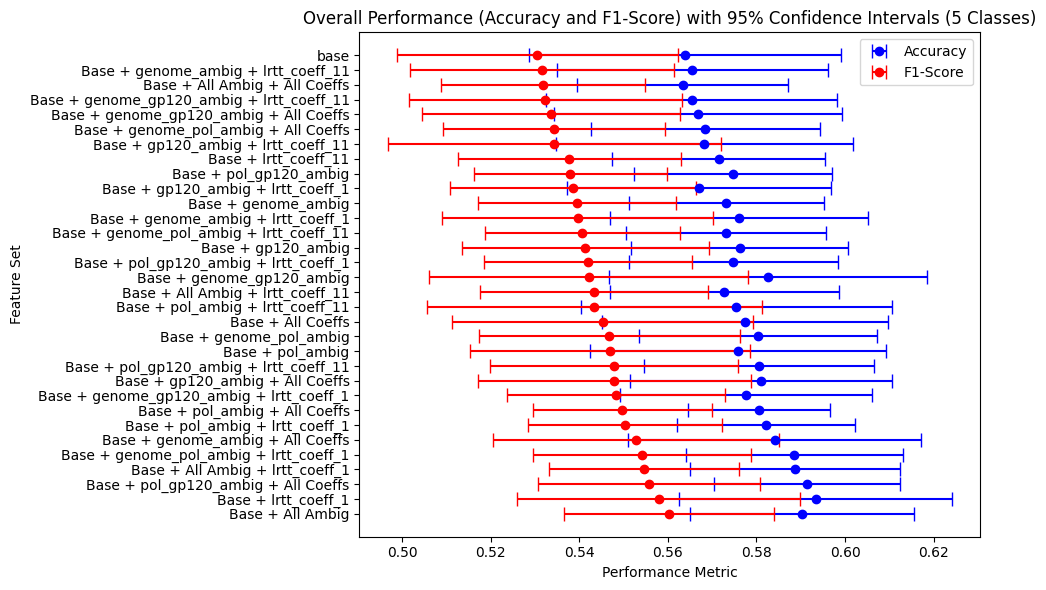

In [54]:
#sort by F1-score
summary_results = summary_results.sort_values(by='mean_f1_score', ascending=False)
plt.figure(figsize=(10, 6))
plt.errorbar(summary_results['mean_accuracy'], summary_results['Feature_Set'],
             xerr=summary_results['ci_accuracy'], fmt='o', capsize=5, label='Accuracy', color='b')
plt.errorbar(summary_results['mean_f1_score'], summary_results['Feature_Set'],
             xerr=summary_results['ci_f1_score'], fmt='o', capsize=5, label='F1-Score', color='r')
plt.title('Overall Performance (Accuracy and F1-Score) with 95% Confidence Intervals (5 Classes)')
plt.ylabel('Feature Set')  
plt.xlabel('Performance Metric')
plt.legend()
plt.tight_layout()
plt.show()

### filter and sorted

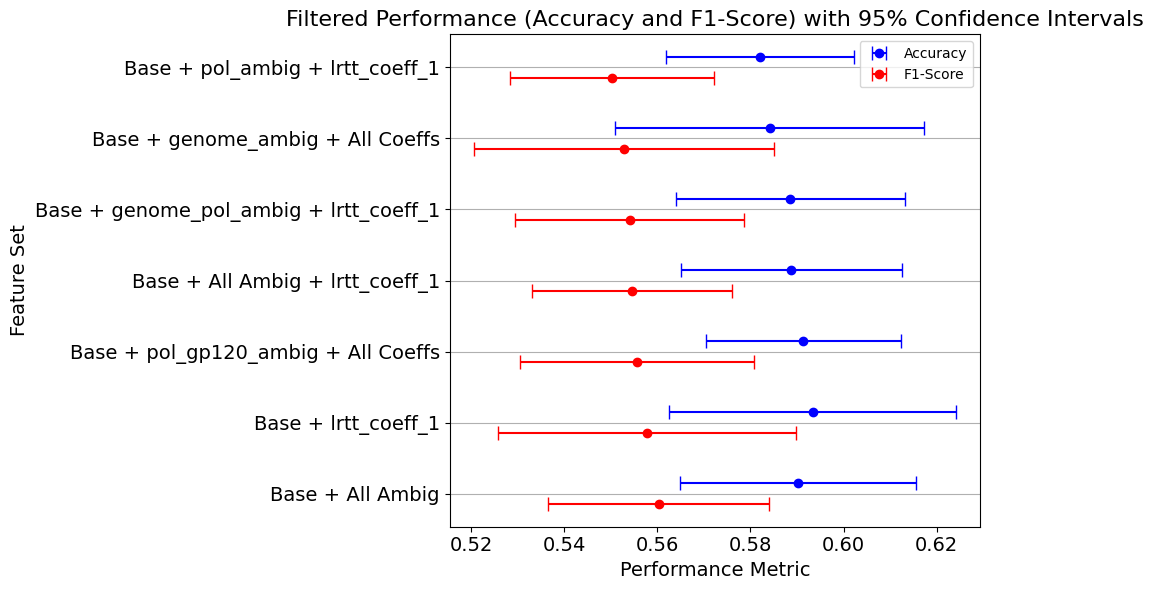

In [55]:
#exclude lower performing sets
filtered_results = summary_results[summary_results['mean_f1_score'] > 0.55]

y_positions = np.arange(len(filtered_results))
offset = 0.15
# Plotting overall performance with confidence intervals (filtered)
plt.figure(figsize=(10, 6))
plt.errorbar(filtered_results['mean_accuracy'], y_positions + offset,
             xerr=filtered_results['ci_accuracy'], fmt='o', capsize=5, label='Accuracy', color='b')

plt.errorbar(filtered_results['mean_f1_score'], y_positions - offset,
             xerr=filtered_results['ci_f1_score'], fmt='o', capsize=5, label='F1-Score', color='r')

plt.yticks(y_positions, filtered_results['Feature_Set'], size = 14)
plt.xticks(size = 14)
plt.title('Filtered Performance (Accuracy and F1-Score) with 95% Confidence Intervals', size = 16)
plt.ylabel('Feature Set', size = 14) 
plt.xlabel('Performance Metric', size = 14)
plt.legend()
plt.grid(True, axis = 'y')
plt.tight_layout()
plt.savefig('./outputs/classifier/multiclass/accuracy_f1_comparison.pdf')
plt.show()

In [56]:
def calculate_ci(data):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data)
    ci = 1.96 * (std / np.sqrt(n))
    return mean, ci

class_mapping = {
    0: '0m-6m',
    1: '6m-12m',
    2: '12m-24m',
    3: '2y-4y',
    4: '4y+'
}

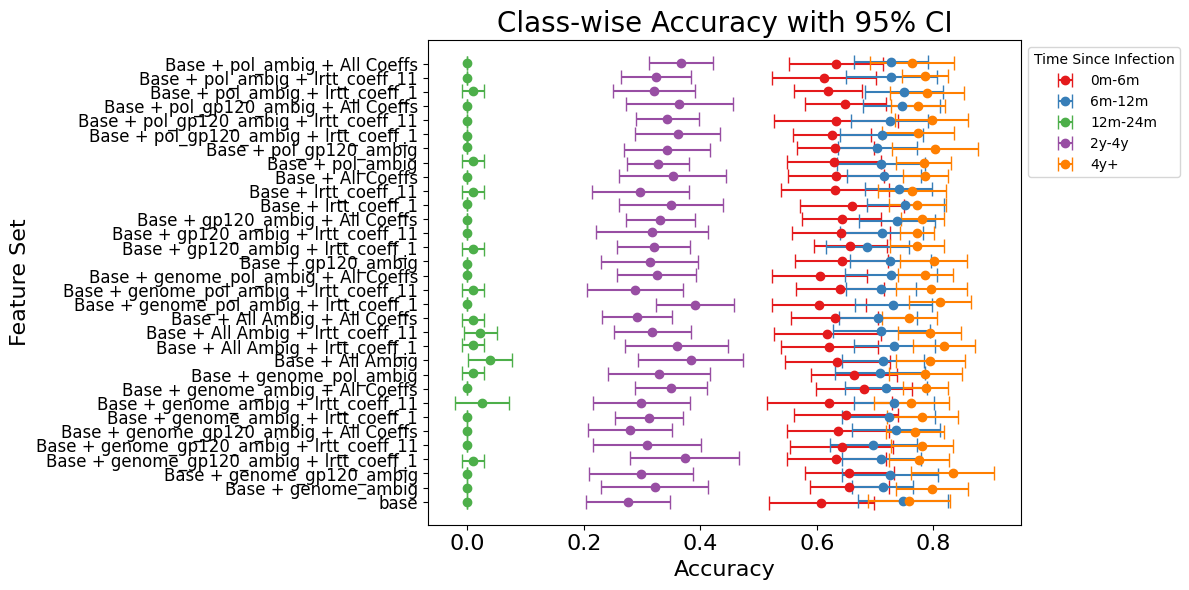

In [57]:
ci_data = []
ordered_classes = [0, 1, 2, 3, 4]  #map to TSI categories

for feature_set in all_class_wise_accuracies['Feature_Set'].unique():
    for cls in ordered_classes:
        class_data = all_class_wise_accuracies[
            (all_class_wise_accuracies['Feature_Set'] == feature_set) & 
            (all_class_wise_accuracies['Class'] == cls)
        ]['Accuracy']
        
        mean_accuracy, ci = calculate_ci(class_data)
        ci_data.append({
            'Feature_Set': feature_set,
            'Class': cls,
            'Mean_Accuracy': mean_accuracy,
            'CI': ci
        })

ci_df = pd.DataFrame(ci_data)
ci_df['Feature_Set_Numeric'] = ci_df['Feature_Set'].astype('category').cat.codes
ci_df = abbreviate_feature_sets(ci_df) #change the feature set names 

plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set1", n_colors=len(ordered_classes))

for idx, cls in enumerate(ordered_classes):
    subset = ci_df[ci_df['Class'] == cls]
    jitter = np.random.normal(loc=0, scale=0.06, size=len(subset))
    plt.errorbar(subset['Mean_Accuracy'], subset['Feature_Set_Numeric'] + jitter,
                 xerr=subset['CI'], fmt='o', label=class_mapping[cls], color=colors[idx], capsize=5)

plt.yticks(ticks=ci_df['Feature_Set_Numeric'].unique(), labels=ci_df['Feature_Set'].unique(), size=12)
plt.xticks(size=16)
plt.title('Class-wise Accuracy with 95% CI', size = 20)
plt.xlabel('Accuracy', size=16)
plt.ylabel('Feature Set', size=16)
plt.legend(title='Time Since Infection', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./outputs/classifier/multiclass/5classwise_accuracy.pdf')
plt.show()

In [58]:
class_offsets = {
    0: 0.12,  # Class 0 (0m-6m) moves up
    1: 0.04,  # Class 1 (6m-12m) moves slightly up
    2: 0.00,  # Class 2 (12m-24m) remains in the middle
    3: -0.06, # Class 3 (2y-4y) moves slightly down
    4: -0.02  # Class 4 (4y+) moves down
}

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_85363/3409425661.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ci_df_filtered['Feature_Set_Numeric'] = ci_df_filtered['Feature_Set'].astype('category').cat.codes


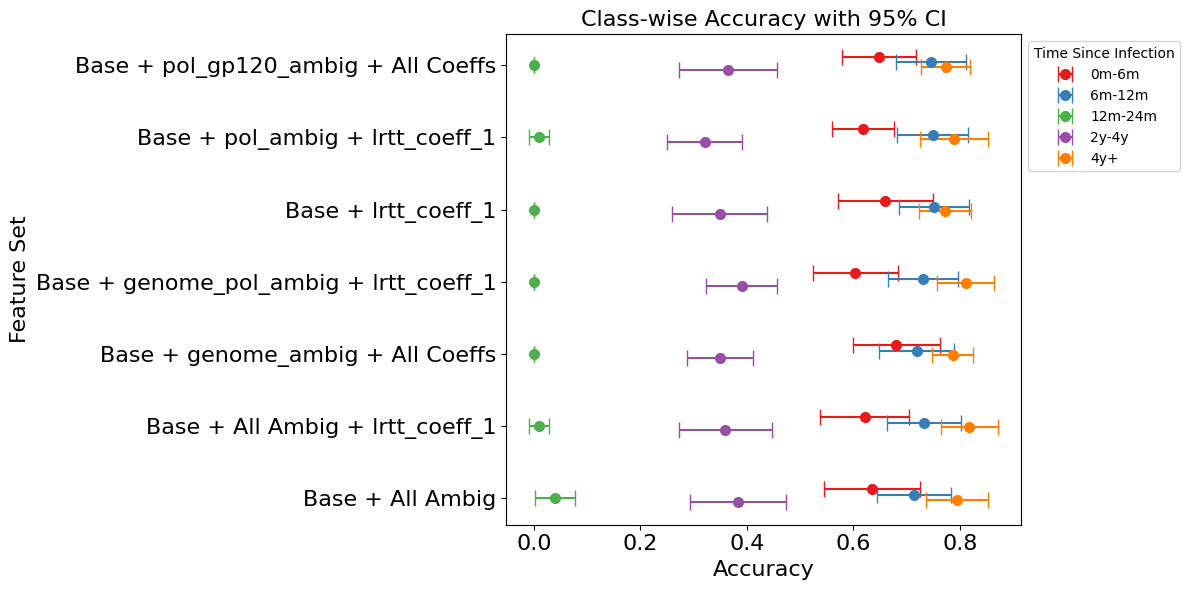

In [59]:
filtered_feature_sets = filtered_results['Feature_Set'].unique()
ci_df_filtered = ci_df[ci_df['Feature_Set'].isin(filtered_feature_sets)]
ci_df_filtered['Feature_Set_Numeric'] = ci_df_filtered['Feature_Set'].astype('category').cat.codes

# Plotting the filtered class-wise accuracies
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set1", n_colors=len(ordered_classes))

# Plotting each class with fixed offsets
for idx, cls in enumerate(ordered_classes):
    subset = ci_df_filtered[ci_df_filtered['Class'] == cls]
    # Apply the fixed offset for each class
    plt.errorbar(subset['Mean_Accuracy'], subset['Feature_Set_Numeric'] + class_offsets[cls],
                 xerr=subset['CI'], fmt='o', label=class_mapping[cls], color=colors[idx], capsize=6, markersize = 7)

plt.yticks(ticks=ci_df_filtered['Feature_Set_Numeric'].unique(),
           labels=ci_df_filtered['Feature_Set'].unique(), size=16)
plt.xticks(size=16)
plt.title('Class-wise Accuracy with 95% CI', size = 16)
plt.xlabel('Accuracy', size=16)
plt.ylabel('Feature Set', size=16)
plt.legend(title='Time Since Infection', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./outputs/classifier/multiclass/5classwise_accuracy_filtered.pdf')
plt.show()

# Four-Class Classification Model

In [64]:
all_results_4 = pd.DataFrame()
all_class_wise_accuracies_list_4 = []

tsi_order_4 = ['0m-6m', '6m-12m', '1y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order_4])

for feature_set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {feature_set_name}")
    
    # Initialize lists to store metrics for each fold
    accuracy_scores = []
    f1_scores = []
    
    # Iterate through each fold of 10
    for fold in range(1, 11):
        # Load the pre-split training and test data for the current fold
        train_file = os.path.join(data_dir, f'training_data_fold{fold}.csv')
        test_file = os.path.join(data_dir, f'test_data_fold{fold}.csv')
        
        train_data = pd.read_csv(train_file)
        test_data = pd.read_csv(test_file)
        
        # Apply the four-class stratification (stratify4()) to both train and test datasets
        train_data = stratify4(train_data) 
        test_data = stratify4(test_data)
        
        # Encode TSI categories as ordinal (for four classes)
        train_data['TSI_encoded'] = ordinal_encoder.fit_transform(train_data[['TSI_category']])
        test_data['TSI_encoded'] = ordinal_encoder.transform(test_data[['TSI_category']])

        # Separate features and target variables
        X_train = train_data[features]
        y_train = train_data['TSI_encoded']
        X_test = test_data[features]
        y_test = test_data['TSI_encoded']  
        
        # Train the RandomForestClassifier model
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store overall fold metrics
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}, F1-score = {f1:.4f}")
        
        # Calculate class-wise accuracies for four classes
        classes = np.unique(y_train)
        for cls in classes:
            mask = y_test == cls
            if np.sum(mask) > 0:
                class_accuracy = accuracy_score(y_test[mask], y_pred[mask])
            else:
                class_accuracy = np.nan  
            
            all_class_wise_accuracies_list_4.append({
                'Feature_Set': feature_set_name,
                'Fold': fold,
                'Class': cls,
                'Accuracy': class_accuracy
            })

    # Append fold-wise metrics to the results DataFrame
    results_df = pd.DataFrame({
        'Feature_Set': feature_set_name,
        'Fold': range(1, 11),
        'Accuracy': accuracy_scores,
        'F1_Score': f1_scores
    })
    
    all_results_4 = pd.concat([all_results_4, results_df], ignore_index=True)
    
# Convert class-wise accuracies list to DataFrame
all_class_wise_accuracies_4 = pd.DataFrame(all_class_wise_accuracies_list_4)

Evaluating feature set: base
Fold 1: Accuracy = 0.5000, F1-score = 0.5305
Fold 2: Accuracy = 0.6333, F1-score = 0.6183
Fold 3: Accuracy = 0.5873, F1-score = 0.5829
Fold 4: Accuracy = 0.5469, F1-score = 0.5298
Fold 5: Accuracy = 0.6212, F1-score = 0.6257
Fold 6: Accuracy = 0.5873, F1-score = 0.5851
Fold 7: Accuracy = 0.6716, F1-score = 0.6637
Fold 8: Accuracy = 0.6613, F1-score = 0.6669
Fold 9: Accuracy = 0.5781, F1-score = 0.5492
Fold 10: Accuracy = 0.6094, F1-score = 0.5991
Evaluating feature set: base_plus_genome_ambig
Fold 1: Accuracy = 0.4848, F1-score = 0.5160
Fold 2: Accuracy = 0.6833, F1-score = 0.6715
Fold 3: Accuracy = 0.5556, F1-score = 0.5414
Fold 4: Accuracy = 0.5781, F1-score = 0.5708
Fold 5: Accuracy = 0.6061, F1-score = 0.6144
Fold 6: Accuracy = 0.5714, F1-score = 0.5691
Fold 7: Accuracy = 0.6119, F1-score = 0.6177
Fold 8: Accuracy = 0.6935, F1-score = 0.6968
Fold 9: Accuracy = 0.5625, F1-score = 0.5514
Fold 10: Accuracy = 0.5625, F1-score = 0.5600
Evaluating feature set

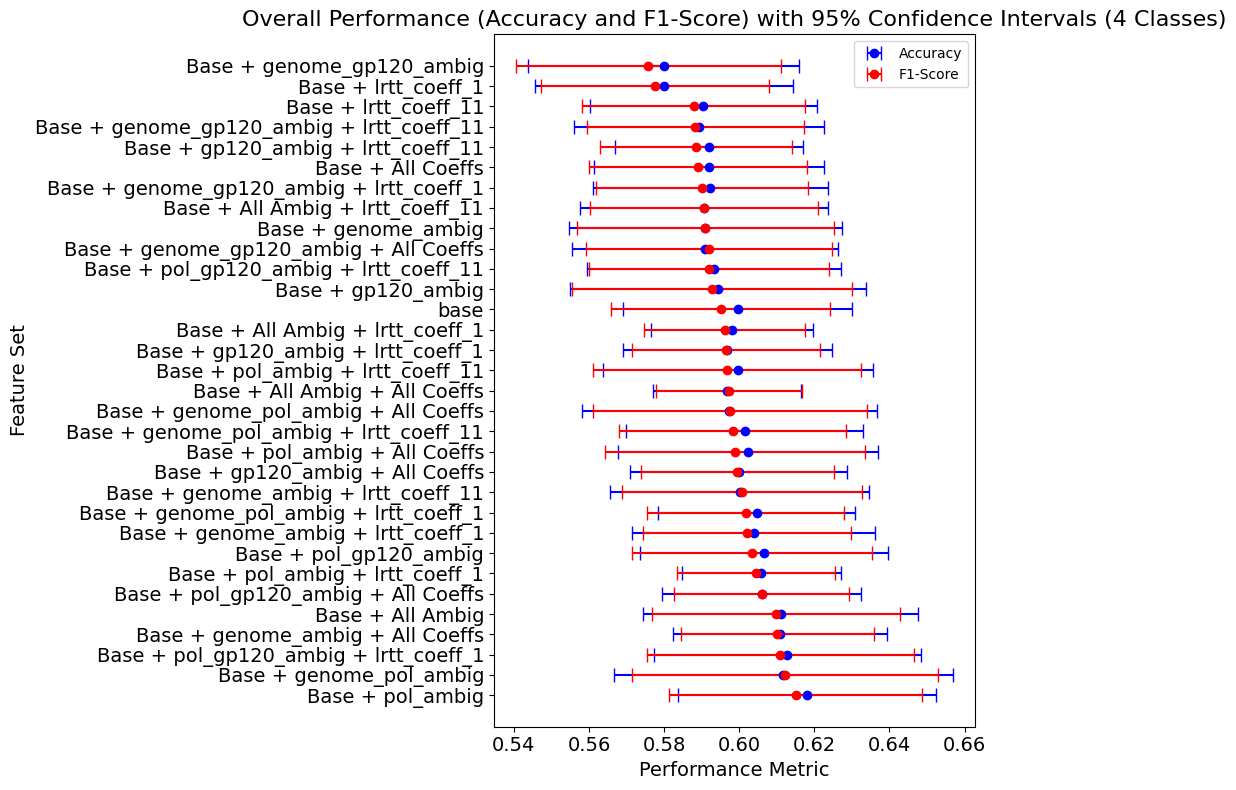

In [65]:
summary_results_4 = all_results_4.groupby('Feature_Set').agg(
    mean_accuracy=('Accuracy', 'mean'),
    mean_f1_score=('F1_Score', 'mean'),
    ci_accuracy=('Accuracy', lambda x: 1.96 * np.std(x) / np.sqrt(len(x))),
    ci_f1_score=('F1_Score', lambda x: 1.96 * np.std(x) / np.sqrt(len(x)))
).reset_index()

summary_results_4 = abbreviate_feature_sets(summary_results_4)
summary_results_4 = summary_results_4.sort_values(by='mean_f1_score', ascending=False)

plt.figure(figsize=(10, 8))
plt.errorbar(summary_results_4['mean_accuracy'], summary_results_4['Feature_Set'],
             xerr=summary_results_4['ci_accuracy'], fmt='o', capsize=5, label='Accuracy', color='b')
plt.errorbar(summary_results_4['mean_f1_score'], summary_results_4['Feature_Set'],
             xerr=summary_results_4['ci_f1_score'], fmt='o', capsize=5, label='F1-Score', color='r')
plt.title('Overall Performance (Accuracy and F1-Score) with 95% Confidence Intervals (4 Classes)', size = 16)
plt.ylabel('Feature Set', size = 14)  
plt.xlabel('Performance Metric', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.legend()
plt.tight_layout()
plt.savefig('./outputs/classifier/multiclass/accuracy_f1_comparison_4class.pdf')
plt.show()

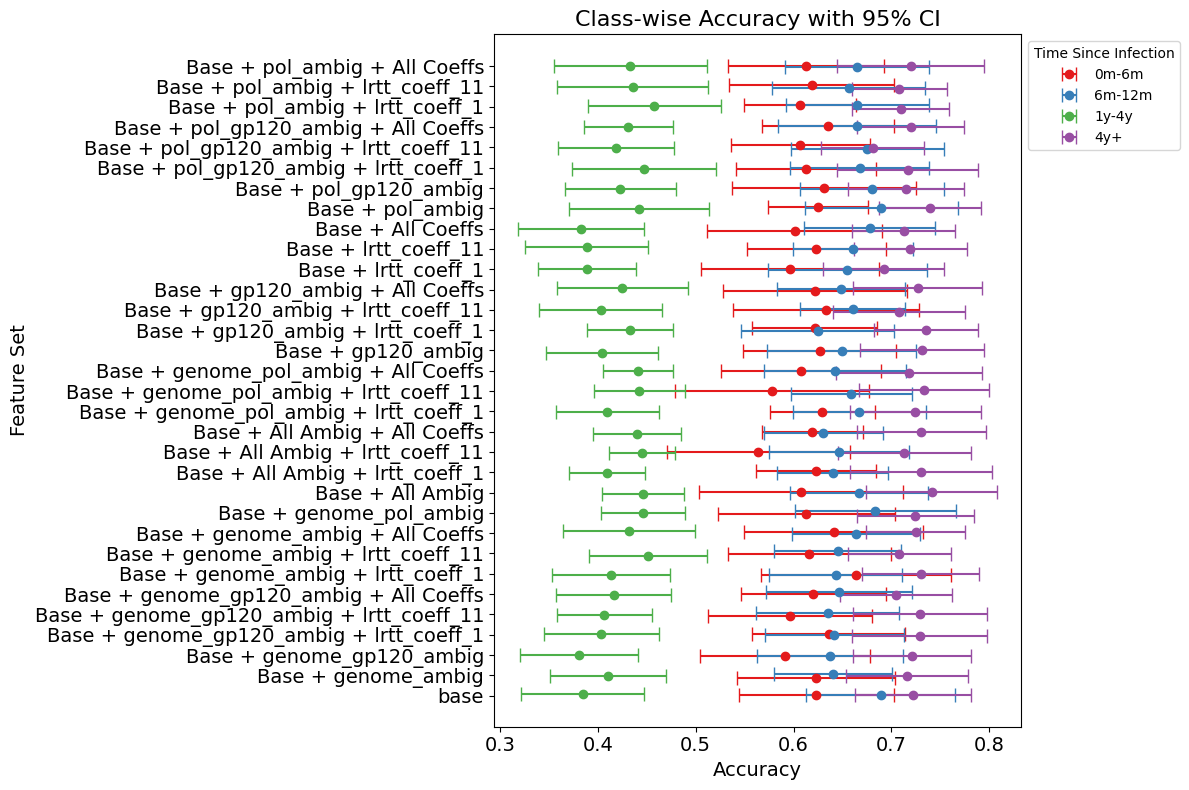

In [66]:
ci_data_4 = []
class_mapping_4 = {
    0: '0m-6m',
    1: '6m-12m',
    2: '1y-4y',
    3: '4y+'
    
}
ordered_classes_4 = [0, 1, 2, 3] 

for feature_set in all_class_wise_accuracies_4['Feature_Set'].unique():
    for cls in ordered_classes_4:
        class_data = all_class_wise_accuracies_4[
            (all_class_wise_accuracies_4['Feature_Set'] == feature_set) & 
            (all_class_wise_accuracies_4['Class'] == cls)
        ]['Accuracy']
        
        mean_accuracy, ci = calculate_ci(class_data)
        ci_data_4.append({
            'Feature_Set': feature_set,
            'Class': cls,
            'Mean_Accuracy': mean_accuracy,
            'CI': ci
        })

ci_df_4 = pd.DataFrame(ci_data_4)
ci_df_4['Feature_Set_Numeric'] = ci_df_4['Feature_Set'].astype('category').cat.codes
ci_df_4 = abbreviate_feature_sets(ci_df_4) #change the feature set names 

plt.figure(figsize=(12, 8))
colors = sns.color_palette("Set1", n_colors=len(ordered_classes_4))

for idx, cls in enumerate(ordered_classes_4):
    subset = ci_df_4[ci_df_4['Class'] == cls]
    jitter = np.random.normal(loc=0, scale=0.06, size=len(subset))
    plt.errorbar(subset['Mean_Accuracy'], subset['Feature_Set_Numeric'] + jitter,
                 xerr=subset['CI'], fmt='o', label=class_mapping_4[cls], color=colors[idx], capsize=5)

plt.yticks(ticks=ci_df_4['Feature_Set_Numeric'].unique(), labels=ci_df_4['Feature_Set'].unique(), size=14)
plt.xticks(size=14)
plt.title('Class-wise Accuracy with 95% CI', size = 16)
plt.xlabel('Accuracy', size=14)
plt.ylabel('Feature Set', size=14)
plt.legend(title='Time Since Infection', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./outputs/classifier/multiclass/4classwise_accuracy.pdf')
plt.show()

# Final Binary Classifier

In [18]:
all_results_binary = pd.DataFrame()
class_wise_accuracies_list_binary = []

for feature_set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {feature_set_name}")
    
    # Initialize lists to store metrics for each fold
    accuracy_scores = []
    f1_scores = []
    
    # Iterate through each fold (assuming 10 folds)
    for fold in range(1, 11):
        # Load the pre-split training and test data for the current fold
        train_file = os.path.join(data_dir, f'training_data_fold{fold}.csv')
        test_file = os.path.join(data_dir, f'test_data_fold{fold}.csv')
        
        train_data = pd.read_csv(train_file)
        test_data = pd.read_csv(test_file)

        # Create binary labels based on TSI_days
        train_data['recency'] = np.where(train_data['TSI_days'] <= 365, 1, 0)
        test_data['recency'] = np.where(test_data['TSI_days'] <= 365, 1, 0)

        # Separate features and target variables
        X_train = train_data[features]
        y_train = train_data['recency']
        X_test = test_data[features]
        y_test = test_data['recency']
        
        # Train the RandomForestClassifier model (binary classification)
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')  # Use 'binary' for F1 in binary classification
        
        # Store overall fold metrics
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}, F1-score = {f1:.4f}")
    
        # Class-wise accuracy calculation
        classes = np.unique(y_test)  # Get the unique class labels (0 and 1)
        for cls in classes:
            mask = y_test == cls  # Create a mask for the current class
            if np.sum(mask) > 0:
                class_accuracy = accuracy_score(y_test[mask], y_pred[mask])
            else:
                class_accuracy = np.nan  # Handle cases where no samples of this class are present in this fold
            
            # Append class-wise accuracy to list
            class_wise_accuracies_list_binary.append({
                'Feature_Set': feature_set_name,
                'Fold': fold,
                'Class': cls,
                'Accuracy': class_accuracy
            })
    # Append fold-wise metrics to the results DataFrame
    results_df = pd.DataFrame({
        'Feature_Set': feature_set_name,
        'Fold': range(1, 11),
        'Accuracy': accuracy_scores,
        'F1_Score': f1_scores
    })
    
    all_results_binary = pd.concat([all_results_binary, results_df], ignore_index=True)
class_wise_accuracies_binary = pd.DataFrame(class_wise_accuracies_list_binary)


Evaluating feature set: base
Fold 1: Accuracy = 0.6515, F1-score = 0.6761
Fold 2: Accuracy = 0.7833, F1-score = 0.8354
Fold 3: Accuracy = 0.7460, F1-score = 0.7500
Fold 4: Accuracy = 0.8125, F1-score = 0.7931
Fold 5: Accuracy = 0.8333, F1-score = 0.8406
Fold 6: Accuracy = 0.7778, F1-score = 0.7742
Fold 7: Accuracy = 0.8507, F1-score = 0.8571
Fold 8: Accuracy = 0.8387, F1-score = 0.8077
Fold 9: Accuracy = 0.7812, F1-score = 0.8108
Fold 10: Accuracy = 0.7656, F1-score = 0.8000
Evaluating feature set: base_plus_genome_ambig
Fold 1: Accuracy = 0.7576, F1-score = 0.7895
Fold 2: Accuracy = 0.7833, F1-score = 0.8267
Fold 3: Accuracy = 0.7778, F1-score = 0.7879
Fold 4: Accuracy = 0.8125, F1-score = 0.7931
Fold 5: Accuracy = 0.8182, F1-score = 0.8235
Fold 6: Accuracy = 0.8095, F1-score = 0.8000
Fold 7: Accuracy = 0.8507, F1-score = 0.8571
Fold 8: Accuracy = 0.8387, F1-score = 0.8000
Fold 9: Accuracy = 0.7969, F1-score = 0.8219
Fold 10: Accuracy = 0.7656, F1-score = 0.8000
Evaluating feature set

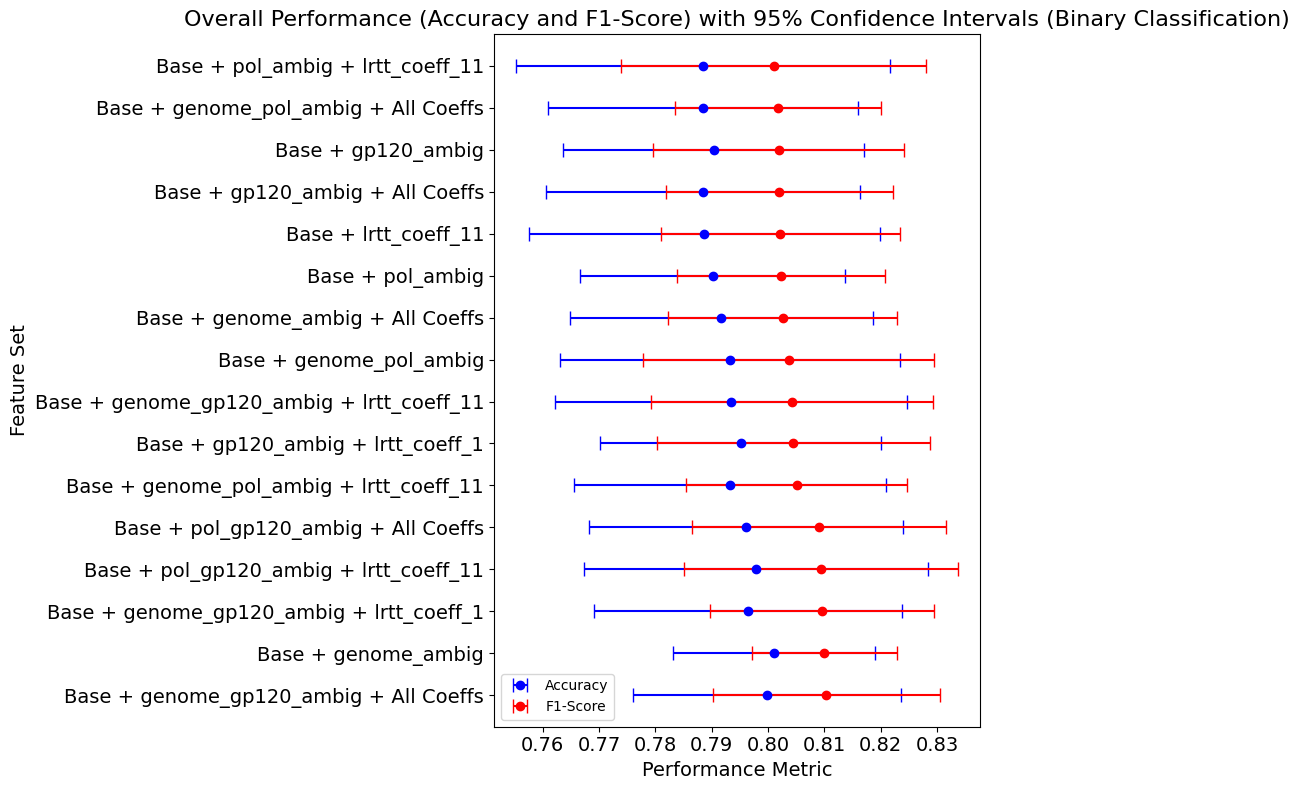

In [39]:
# Summary Results with Confidence Intervals
summary_binary = all_results_binary.groupby('Feature_Set').agg(
    mean_accuracy=('Accuracy', 'mean'),
    mean_f1_score=('F1_Score', 'mean'),
    ci_accuracy=('Accuracy', lambda x: 1.96 * np.std(x) / np.sqrt(len(x))),
    ci_f1_score=('F1_Score', lambda x: 1.96 * np.std(x) / np.sqrt(len(x)))
).reset_index()

summary_binary = abbreviate_feature_sets(summary_binary) #change the feature set names 
summary_binary = summary_binary.sort_values(by='mean_f1_score', ascending=False)
filtered_binary = summary_binary[summary_binary['mean_f1_score'] > 0.8]

plt.figure(figsize=(10, 8))
plt.errorbar(filtered_binary['mean_accuracy'], filtered_binary['Feature_Set'],
             xerr=filtered_binary['ci_accuracy'], fmt='o', capsize=5, label='Accuracy', color='b')
plt.errorbar(filtered_binary['mean_f1_score'], filtered_binary['Feature_Set'],
             xerr=filtered_binary['ci_f1_score'], fmt='o', capsize=5, label='F1-Score', color='r')
plt.title('Overall Performance (Accuracy and F1-Score) with 95% Confidence Intervals (Binary Classification)', size = 16)
plt.ylabel('Feature Set', size = 14)
plt.xlabel('Performance Metric', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.legend()
plt.tight_layout()
plt.savefig('./outputs/classifier/binary/accuracy_f1_binary_filtered.pdf')
plt.show()

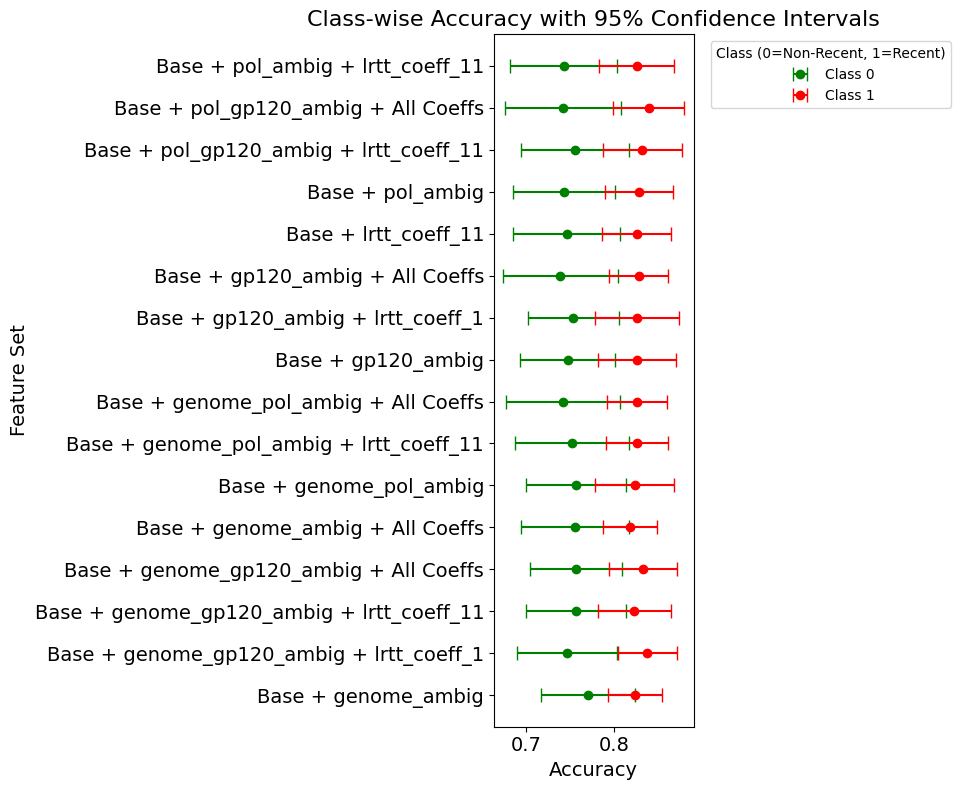

In [40]:
filtered_binary_sets = filtered_binary['Feature_Set'].unique()

# Aggregating mean class accuracy per feature set and class
binary_summary_class_accuracies = class_wise_accuracies_binary.groupby(['Feature_Set', 'Class']).agg(
    mean_accuracy=('Accuracy', 'mean'),
    ci_accuracy=('Accuracy', lambda x: 1.96 * np.std(x) / np.sqrt(len(x)))
).reset_index()

binary_summary_class_accuracies = abbreviate_feature_sets(binary_summary_class_accuracies) #change the feature set names 
filtered_binary_classwise = binary_summary_class_accuracies[binary_summary_class_accuracies['Feature_Set'].isin(filtered_binary_sets)]

plt.figure(figsize=(10, 8))
class_colors = {0: 'green', 1: 'red'}  # Class 0 = Non-Recent, Class 1 = Recent

for cls in np.unique(class_wise_accuracies_binary['Class']):
    subset = filtered_binary_classwise[filtered_binary_classwise['Class'] == cls]
    
    plt.errorbar(subset['mean_accuracy'], subset['Feature_Set'],
                 xerr=subset['ci_accuracy'], fmt='o', label=f'Class {cls}', color=class_colors[cls], capsize=5)

plt.title('Class-wise Accuracy with 95% Confidence Intervals', size = 16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel('Accuracy', size = 14)
plt.ylabel('Feature Set', size = 14)
plt.legend(title='Class (0=Non-Recent, 1=Recent)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('./outputs/classifier/binary/classwise_accuracy_binary_filtered.pdf')
plt.show()